# Make anaphase time predictions based on the instataneous surface only with a KNN regressor

First attempt to predict the anaphase time based on the time series of the relative surface feature only. We will use simple simple machine learning algorithms to make our predictions as a first attempt, here the K-nearest neighbours regressor.

Problem formulation $\forall$ division event $i$, $\forall 0< t < t^*$, we want to predict the target variable $y_{i, t} = t_i^* - t$ , the relative time to anaphase(TTA), based on the present feature, $X_{i, t}$ ; i.e. we want $$f : X_{i, t} \mapsto y_{i, t} = t_i^* - t \in \mathbb{R_+^*}$$

This is regression problem, and we will use the classical MSE as a loss function/evaluation metrics.

In [2]:
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
from skimage import measure # to get contours from masks
import sklearn

import napari

sns.set_theme()

## Loading Data

In [5]:
os.chdir("D:/Documents/STAGE/Anaphase/")
data = pd.read_csv("Analysis_BF_f0001-1-100.1.csv", sep=";", comment="#", index_col="idx")
data = data[data["time_to_anaphase"] >= 0]

print(data.shape)
data.head()

(495, 13)


,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf
idx,,,,,,,,,,,,,
0,0,0,463.509804,225.369863,-1.000000,-1.000000,229.730504,0.000000,0.000000,False,0,36,0.000000
0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842
0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853
0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912
0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739


In [13]:
from sklearn.model_selection import train_test_split

features = "cum_relat_surf"

X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["time_to_anaphase"].values, train_size=0.75)
X_train, X_test = X_train.reshape(-1, 1), X_test.reshape(-1, 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(371, 1) (124, 1) (371,) (124,)


## KNN univariate regression 

Here we will try to train a KNN regressor to predict the TTA given the cumulative relative surface at time $t$. This is a dumb regressor, as it will not be bad on average, but learns to predict from single data points (i.e. makes the assumption that all the observations are i.i.d.) instead of taking the cell's history into account and trying to predict, at each time step of a time series, the TTA. As we will see, it will not perform bad on average (RMSE of 5 minutes) and will simply make early predictions on the points that are over the curve (latecomers) and late observations on the points which are under the curve (earlycomers). 

### Training

In [22]:
from sklearn.neighbors import KNeighborsRegressor

lm = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)

print(f"Score : {round(lm.score(X_train, y_train), 2)}")

Score : 0.8


Text(0.5, 1.0, 'Linear regression predictions on the training set')

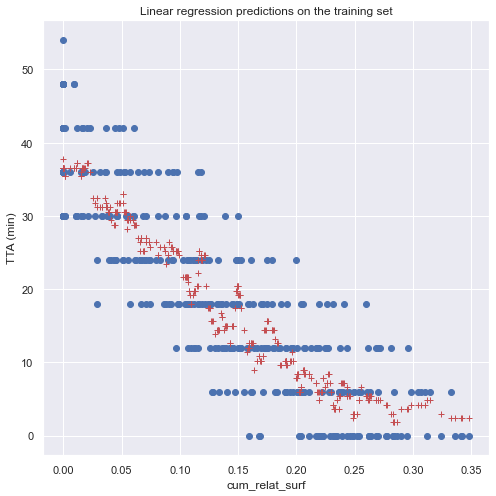

In [23]:
predictions_on_train_set = lm.predict(X_train)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_train, y_train, c='b', label="Train set")
ax.plot(X_train, predictions_on_train_set, "+", c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")

### Evaluation

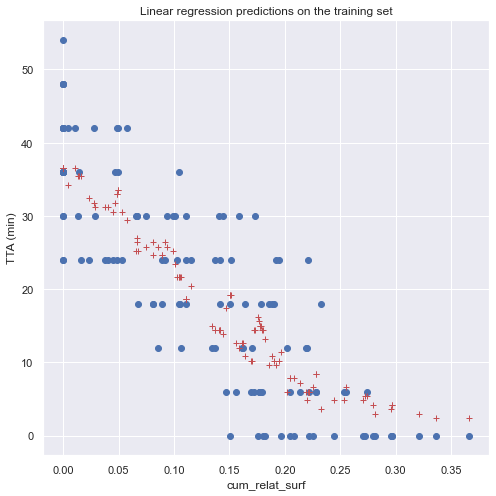

In [24]:
predictions_on_test_set = lm.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(X_test, y_test, c='b', label="Test set")
ax.plot(X_test, predictions_on_test_set, "+", c="r", label="Predictions")
ax.set_xlabel(features)
ax.set_ylabel("TTA (min)")
ax.set_title("Linear regression predictions on the training set")
plt.savefig("Linear Regression", format="pdf")

Mean squared error : 6.653225806451611


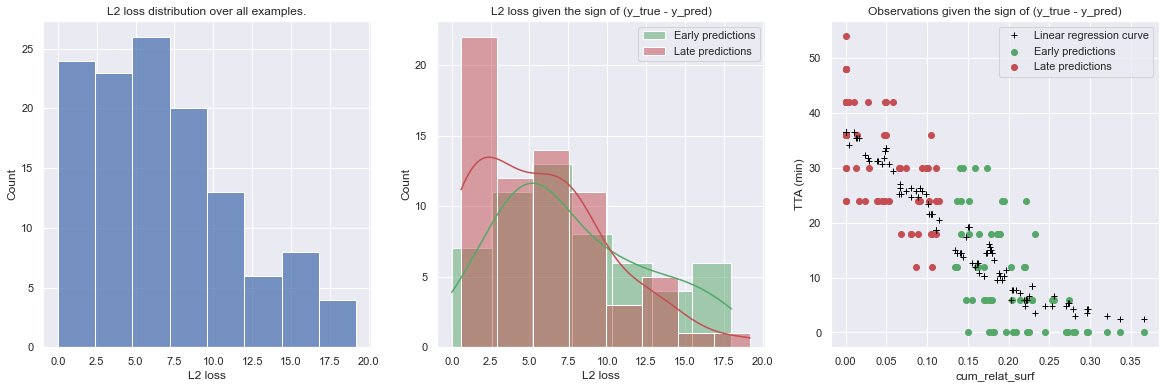

In [25]:
# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {losses.mean()}")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("L2 loss distribution over all examples.")
axes[0].set_xlabel("L2 loss")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

# conditional distributions of the points
axes[2].scatter(X_test[X_test >= X_test.mean()], y_test[(X_test >= X_test.mean()).flatten()], c="g", label="Early predictions")
axes[2].scatter(X_test[X_test < X_test.mean()], y_test[(X_test < X_test.mean()).flatten()], c="r", label="Late predictions")
axes[2].plot(X_test, predictions_on_test_set, "+", c="black", label="Linear regression curve")
axes[2].legend()
axes[2].set_xlabel(features)
axes[2].set_ylabel("TTA (min)")
axes[2].set_title("Observations given the sign of (y_true - y_pred)")
plt.savefig("inear Reg errors", format="pdf")

### Save predictions

In [ ]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data.to_csv(f"KNN_Predictions_{features}_BF_f0001-1-100.csv", sep=";")

contours

## KNN regression taking into account previous time steps

In [32]:
# create a lag 1 feature
feature = "relat_surf"
lags = 1

for l in range(1, lags + 1):
    data[f"{feature}_lag{l}"] = np.nan
    
for idx in data.index.unique():
    for l in range(1, lags + 1):
        data.loc[idx][f"{feature}_lag{l}"] = data.loc[idx][feature].shift(periods=l)

data2 = data.dropna()
            
print(data.shape, data2.shape)

data2.head()

(495, 17) (429, 17)


<ipython-input-32-1d25b635acdc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[idx][f"{feature}_lag{l}"] = data.loc[idx][feature].shift(periods=l)


,frame,time,mom_x,mom_y,daugh_x,daugh_y,mom_surf,daugh_surf,relat_surf,anaphase,anaphase_int,time_to_anaphase,cum_relat_surf,delta_mom_surf,delta_daugh_surf,delta_relat_surf,relat_surf_lag1
idx,,,,,,,,,,,,,,,,,
0,1,6,463.481911,225.084507,460.542099,238.588235,227.730488,9.534260,0.041866,False,0,30,0.020842,2.000015,26.872597,0.116610,0.000000
0,2,12,460.345420,225.602740,456.110886,239.965517,229.730504,36.406857,0.158476,False,0,24,0.066853,-5.000000,15.147087,0.070927,0.041866
0,3,18,460.578297,225.698630,455.691877,240.914286,224.730504,51.553944,0.229403,False,0,18,0.106912,3.715675,17.147087,0.071328,0.158476
0,4,24,461.524165,225.985915,456.054041,241.146341,228.446179,68.701031,0.300732,False,0,12,0.145739,-2.000000,13.147057,0.060714,0.229403
0,5,30,462.524165,226.197183,456.493388,242.023256,226.446179,81.848088,0.361446,False,0,6,0.181476,-7.000000,17.147087,0.089668,0.300732


In [56]:
from sklearn.model_selection import train_test_split

features = [feature] + [f"{feature}_lag{l}" for l in range(1, lags + 1)]

X_train, X_test, y_train, y_test = train_test_split(data2[features].values, data2["time_to_anaphase"].values, train_size=0.80)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(343, 2) (86, 2) (343,) (86,)


### Training

In [57]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=1).fit(X_train, y_train)

print(f"Score : {round(knn.score(X_train, y_train), 2)}")

Score : 1.0


Text(0.5, 1.0, 'Lag-KNN regression predictions on the training set')

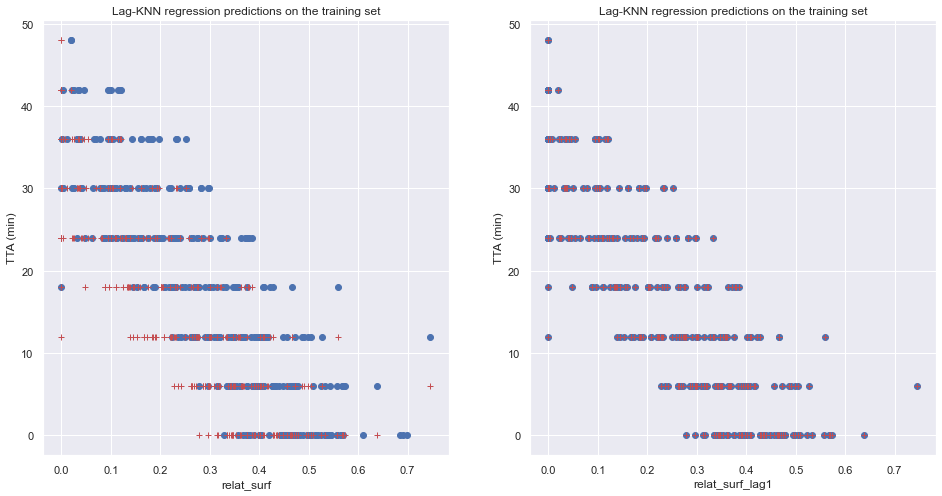

In [58]:
predictions_on_train_set = knn.predict(X_train)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# first dim
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Train set")
ax[0].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[0].set_xlabel(features[0])
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Lag-KNN regression predictions on the training set")

# second dim
ax[1].scatter(X_train[:, 1], y_train, c='b', label="Train set")
ax[1].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[1].set_xlabel(features[1])
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Lag-KNN regression predictions on the training set")

### Evaluation

Text(0.5, 1.0, 'Lag-KNN regression predictions on the test set')

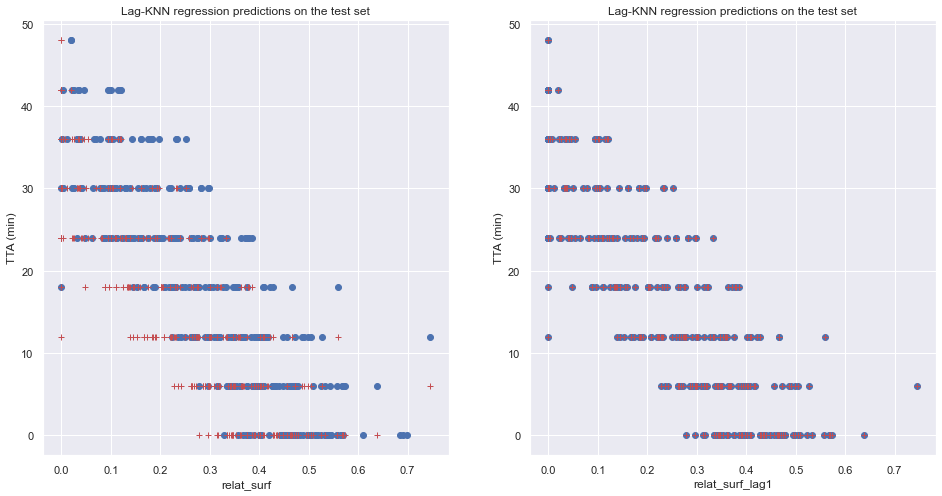

In [59]:
predictions_on_test_set = knn.predict(X_test)

fig, ax = plt.subplots(1, 2, figsize=(16, 8))

# first dim
ax[0].scatter(X_train[:, 0], y_train, c='b', label="Test set")
ax[0].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[0].set_xlabel(features[0])
ax[0].set_ylabel("TTA (min)")
ax[0].set_title("Lag-KNN regression predictions on the test set")

# second dim
ax[1].scatter(X_train[:, 1], y_train, c='b', label="Test set")
ax[1].plot(X_train[:, 1], predictions_on_train_set, "+", c="r", label="Predictions")
ax[1].set_xlabel(features[1])
ax[1].set_ylabel("TTA (min)")
ax[1].set_title("Lag-KNN regression predictions on the test set")

Mean squared error : 6.0


Text(0.5, 1.0, 'L2 loss given the sign of (y_true - y_pred)')

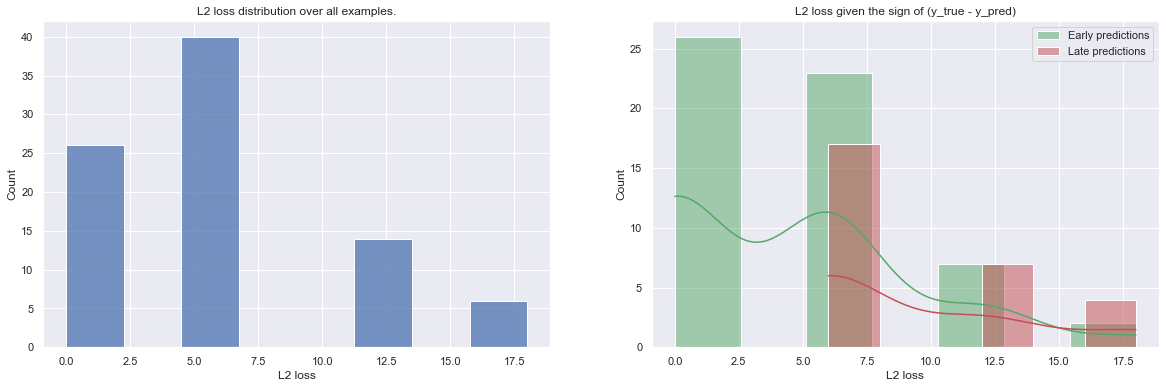

In [62]:
# evaluation with the clasical RMSE
losses, signed_losses = [], []
for obs, pred, gt in zip(X_test, predictions_on_test_set, y_test):
    loss = np.sqrt((pred - gt) ** 2)
    signed_losses.append(gt - pred)
    losses.append(loss)
losses = np.array(losses) 
signed_losses = np.array(signed_losses)

print(f"Mean squared error : {losses.mean()}")

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# RMSE distribution
sns.histplot(losses, ax=axes[0])
axes[0].set_title("L2 loss distribution over all examples.")
axes[0].set_xlabel("L2 loss")

# Conditional distributions given the sign of the error
sns.histplot(losses[signed_losses >= 0], color="g", kde=True, label="Early predictions", ax=axes[1])
sns.histplot(losses[signed_losses < 0], color="r", kde=True, label="Late predictions", ax=axes[1])
axes[1].legend()
axes[1].set_xlabel("L2 loss")
axes[1].set_title("L2 loss given the sign of (y_true - y_pred)")

### Save predictions

In [ ]:
os.chdir("D:/Hugo/Anaphase/Analyse_Descriptive")
data.to_csv(f"KNN_Predictions_{features}_BF_f0001-1-100.csv", sep=";")

contours